<a href="https://colab.research.google.com/github/AnastasiiaVladimirovna/transcriptomics_homeworks/blob/main/hw13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages
!pip install scikit-misc scanpy cellrank scvelo python-igraph palantir
!pip install rpy2==3.5.1

# Restart runtime
# (it is needed to update Matplotlib version)
import os
os.kill(os.getpid(), 9)

In [ ]:
%load_ext rpy2.ipython

!Rscript -e 'install.packages("mgcv")'
!Rscript -e 'install.packages("plyr")'
!Rscript -e 'install.packages("dplyr")'
!Rscript -e 'install.packages("ggplot2")'
!Rscript -e 'install.packages("tidymv")'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr
import palantir
%matplotlib inline

# Настроим параметры изображений и степень подробности сообщений 
sc.set_figure_params(figsize=(7, 5))
sns.set_theme(style='whitegrid')
cr.settings.verbosity = 2

# Hide some of the warnings
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
     

In [3]:
adata = cr.datasets.pancreas()
adata

  0%|          | 0.00/33.5M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:

adata.layers["counts"] = adata.X.copy()
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, subset=True, layer="counts", flavor="seurat_v3")

In [5]:
sc.pp.pca(adata)

In [6]:
adata_raw = adata.copy()

## Часть 1

Уберем кластеры, соответствующие дельта- и эпсилон-клеткам

In [7]:
adata = adata_raw.copy()
adata = adata[list((adata.obs['clusters'] != 'Epsilon') & (adata.obs['clusters'] != 'Delta')), :]

In [8]:
adata

View of AnnData object with n_obs × n_vars = 2322 × 1500
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'counts'
    obsp: 'connectivities', 'distances'

Запустим Palantir 

In [9]:
sce.tl.palantir(adata, n_components=5, knn=30)

Determing nearest neighbor graph...


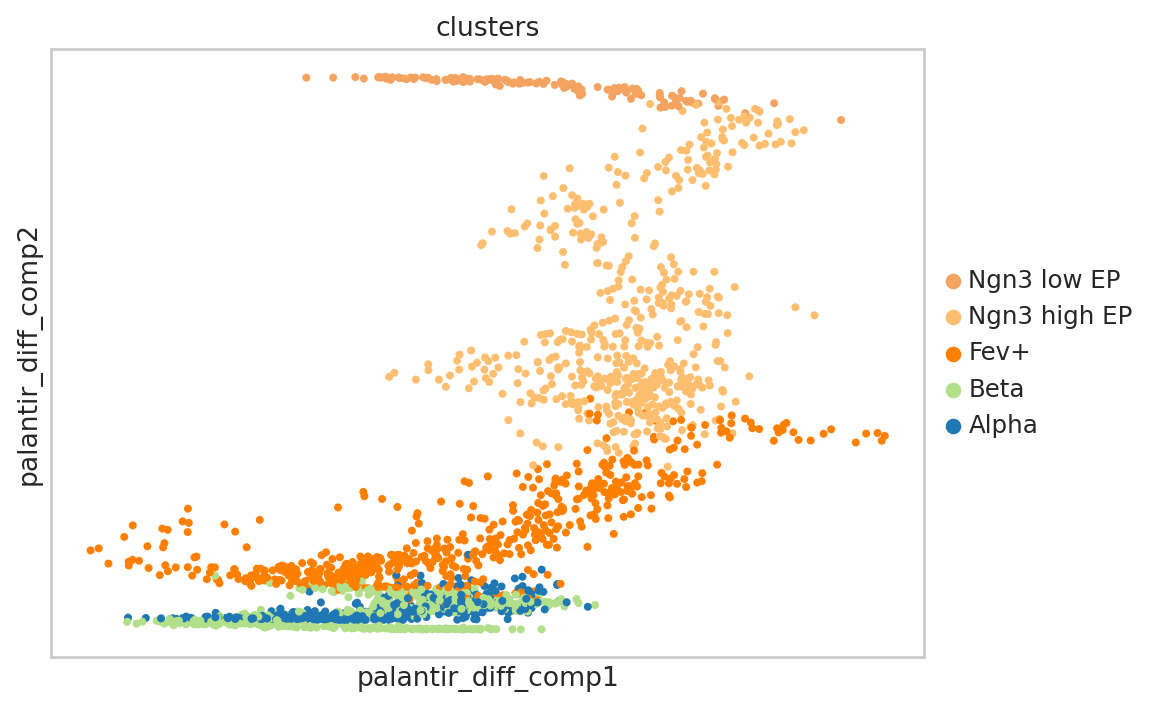

In [10]:
sc.pl.embedding(adata, basis="palantir_diff_comp", color="clusters")

In [11]:
adata.obs["DC1"] = adata.obsm["X_palantir_diff_comp"][:,0]
adata.obs["DC2"] = adata.obsm["X_palantir_diff_comp"][:,1]
adata.obs["DC3"] = adata.obsm["X_palantir_diff_comp"][:,2]

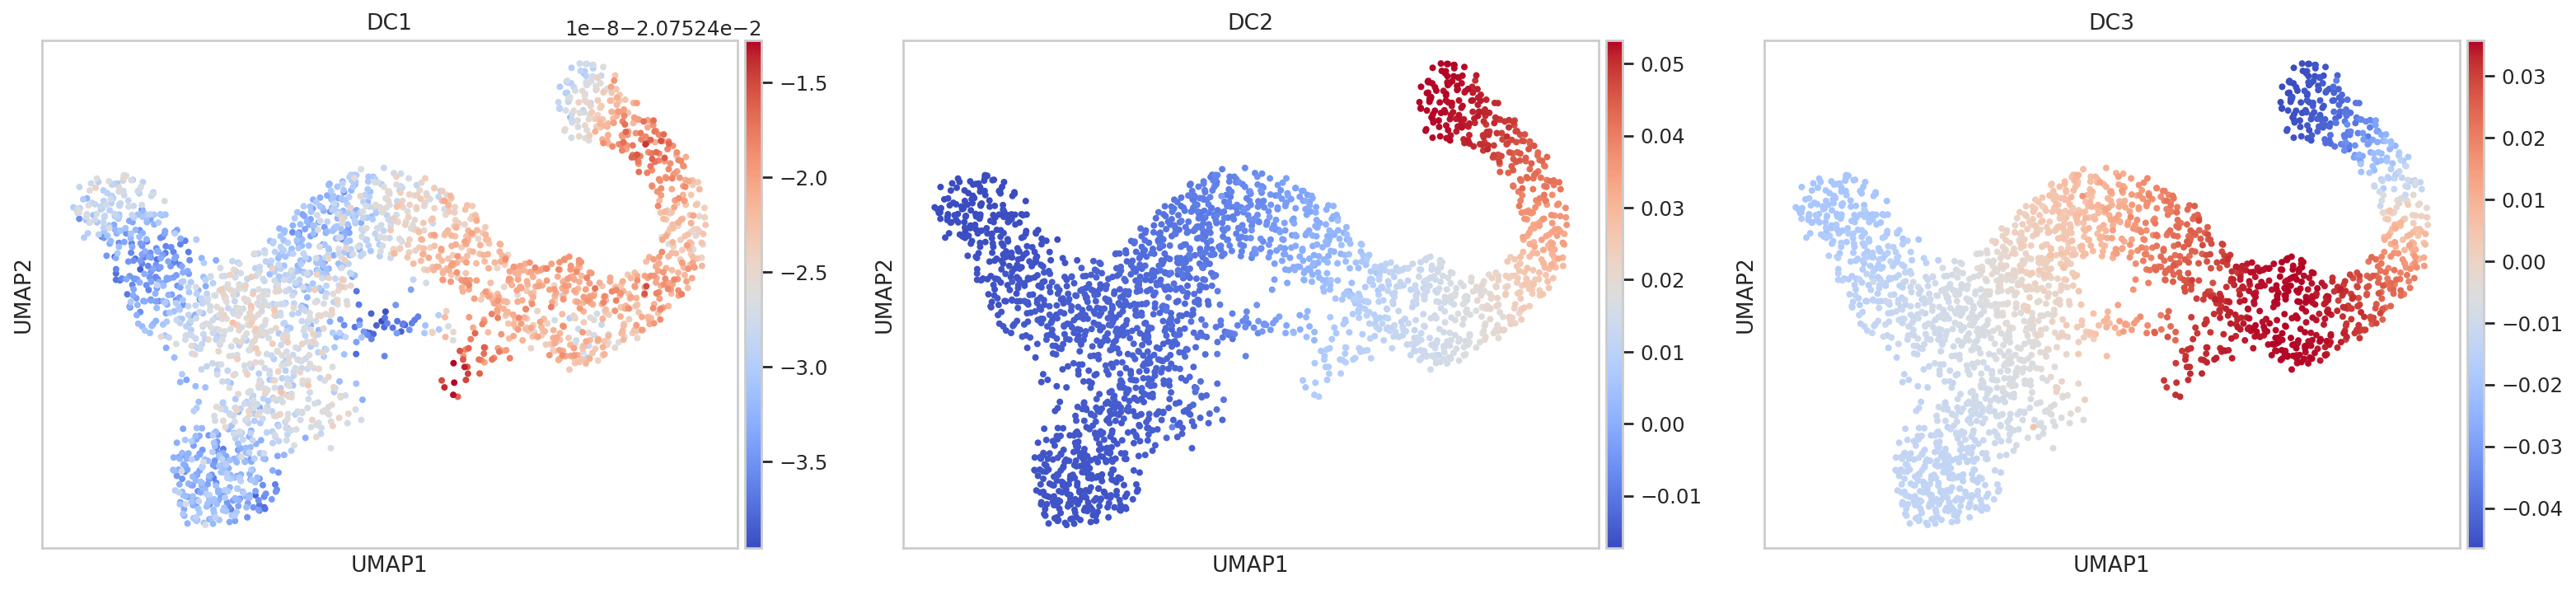

In [12]:
sc.pl.umap(adata, color=["DC1","DC2","DC3"], cmap="coolwarm")

In [13]:
sc.tl.tsne(adata, n_pcs=2, use_rep='X_palantir_multiscale', perplexity=90)

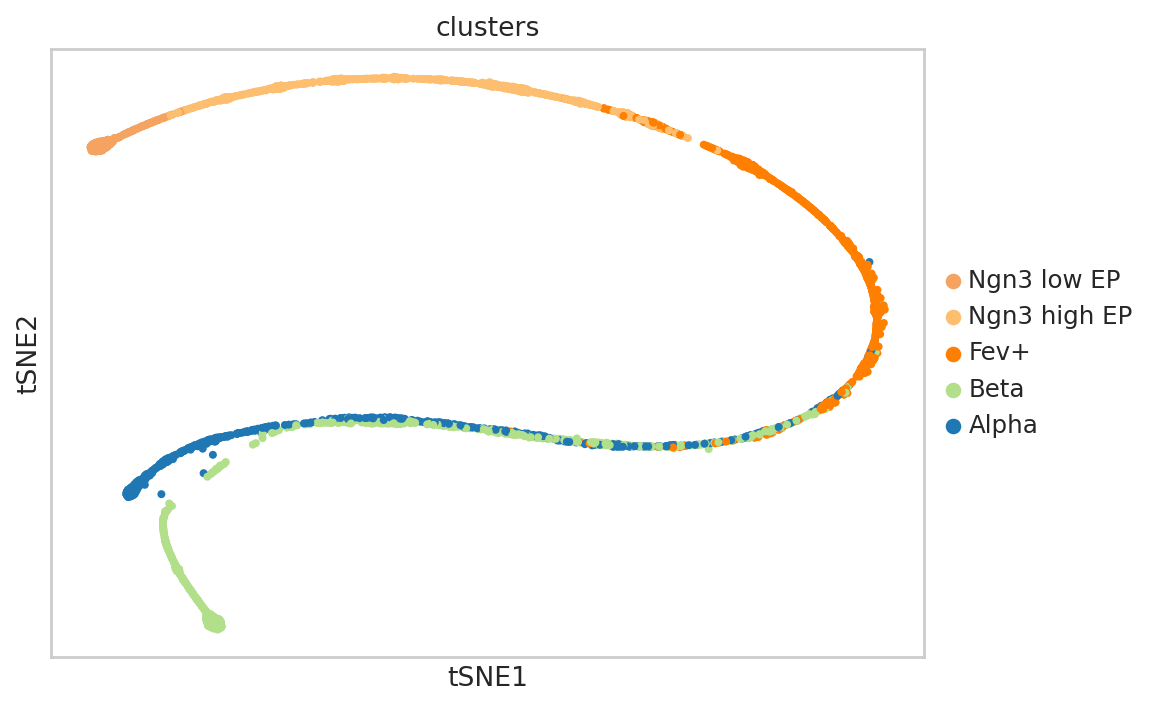

In [14]:
sc.pl.tsne(adata, color="clusters")

In [15]:

cluster_dict = {"Root": adata.obs["clusters"] == "Ngn3 low EP",
                "Alpha": adata.obs["clusters"] == "Alpha",
                "Beta": adata.obs["clusters"] == "Beta"}

In [16]:
root_cell = adata.obs.index[cluster_dict["Root"]][0]
alpha_cell = adata.obs.index[cluster_dict["Alpha"]][15]
beta_cell = adata.obs.index[cluster_dict["Beta"]][10]

cluster_cells = {"Root": adata.obs.index==root_cell,
                "Alpha": adata.obs.index==alpha_cell,
                "Beta": adata.obs.index==beta_cell}

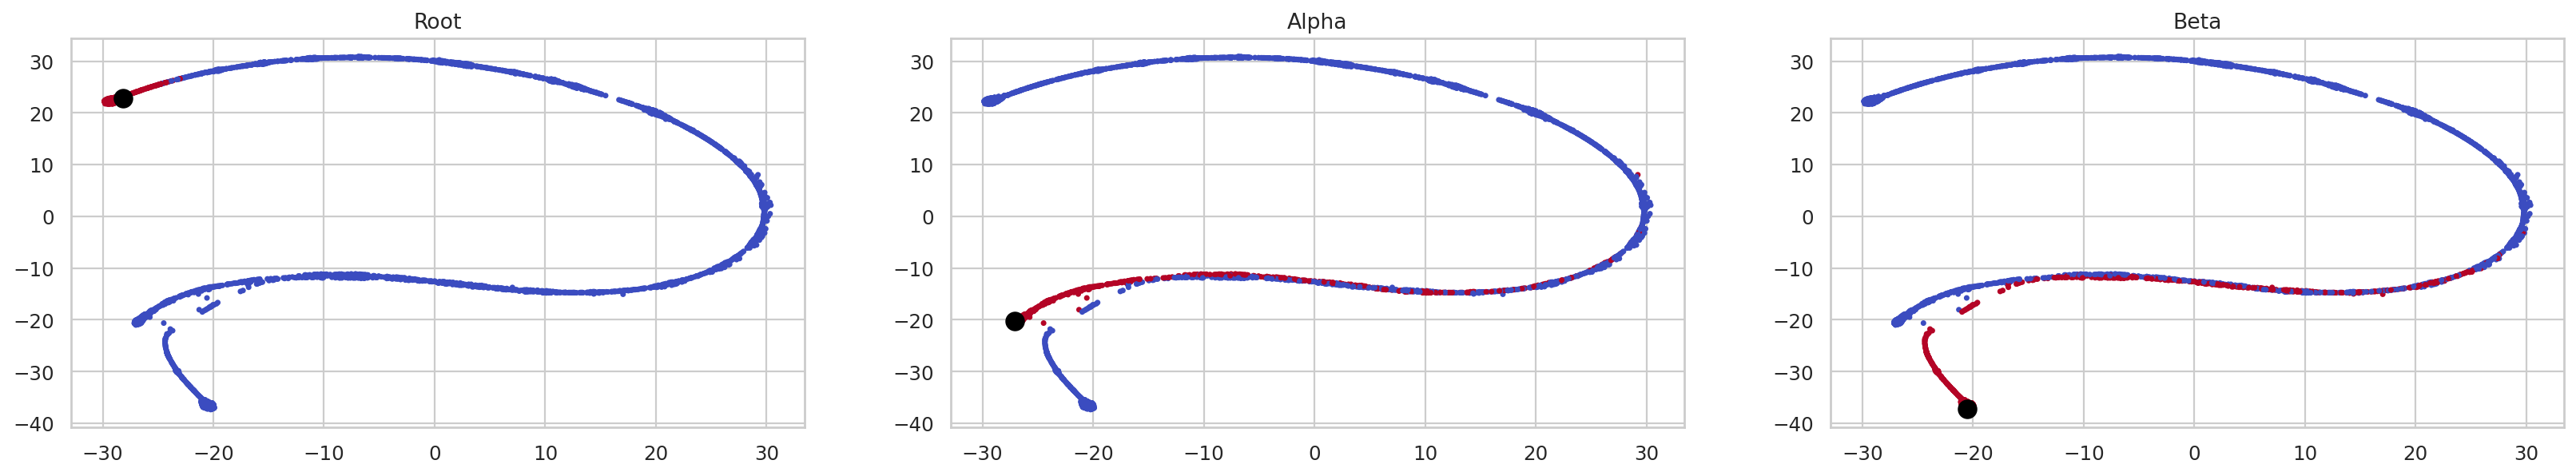

In [17]:

fig,axs = plt.subplots(1,3,figsize=(25,4))
for i, ax in enumerate(fig.axes):
  cur_cluster = list(cluster_dict.keys())[i]
  sns.scatterplot(adata.obsm["X_tsne"][:,0], adata.obsm["X_tsne"][:,1], c=cluster_dict[cur_cluster], ax=ax, cmap="coolwarm", linewidth=0, s=10)
  ax.scatter(adata.obsm["X_tsne"][:,0][cluster_cells[cur_cluster]],
             adata.obsm["X_tsne"][:,1][cluster_cells[cur_cluster]], c="black", s=100)
  ax.set_title(cur_cluster)

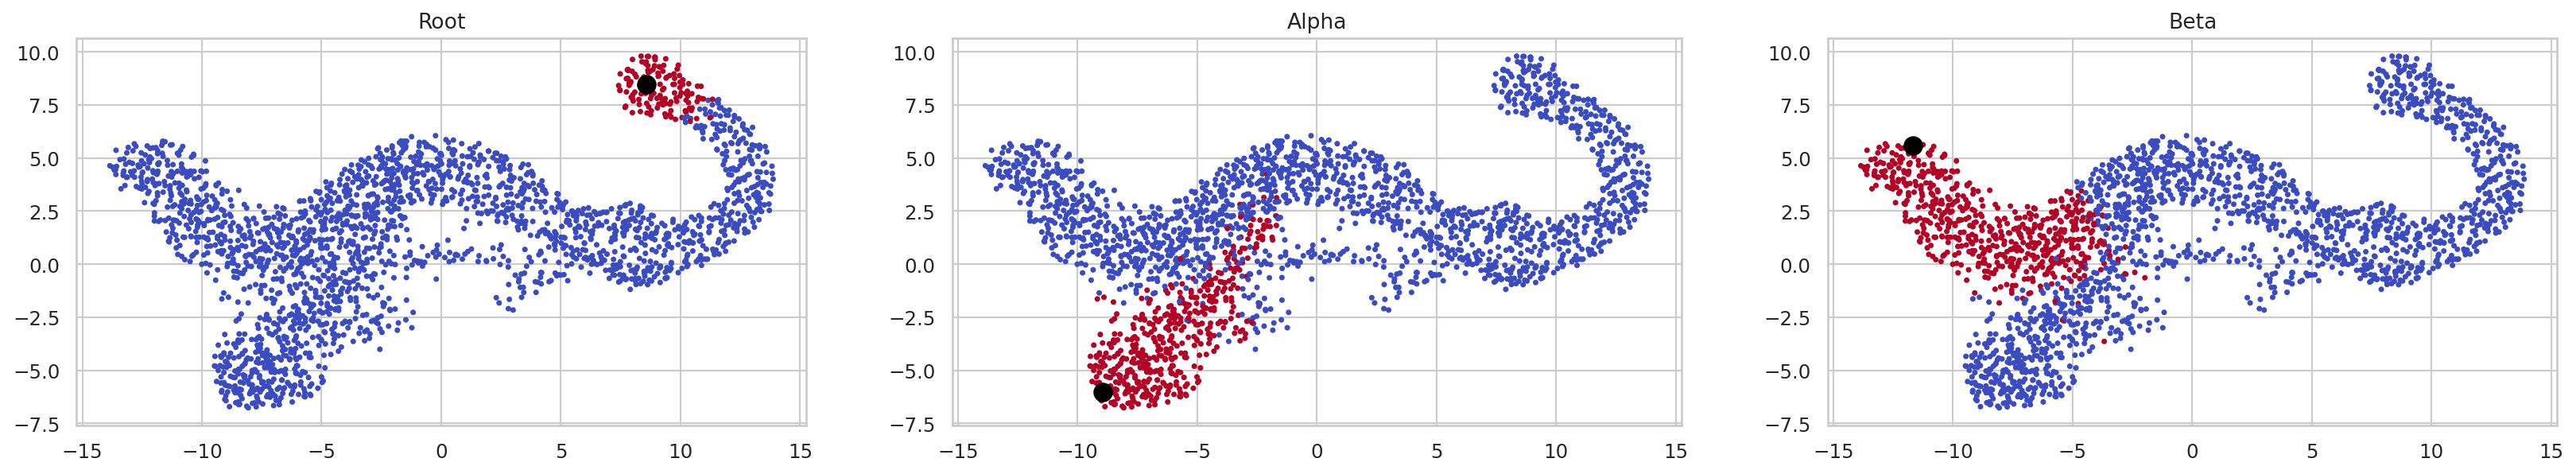

In [18]:
fig,axs = plt.subplots(1,3,figsize=(25,4))
for i, ax in enumerate(fig.axes):
  cur_cluster = list(cluster_dict.keys())[i]
  sns.scatterplot(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1], c=cluster_dict[cur_cluster], ax=ax, cmap="coolwarm", linewidth=0, s=10)
  ax.scatter(adata.obsm["X_umap"][:,0][cluster_cells[cur_cluster]],
             adata.obsm["X_umap"][:,1][cluster_cells[cur_cluster]], c="black", s=100)
  ax.set_title(cur_cluster)

In [19]:
terminal_states = pd.Series(['Alpha', 'Beta'], 
                           index=[alpha_cell, beta_cell])

In [20]:
pr_res = sce.tl.palantir_results(
    adata,
    early_cell=root_cell,
    ms_data='X_palantir_multiscale',
    num_waypoints=500,
    terminal_states = terminal_states.index,
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.004057816664377848 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.1251712679862976 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [21]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

In [22]:
adata.obs["pr_entropy"] = pr_res.entropy
adata.obs["pr_beta"] = pr_res.branch_probs["Beta"]
adata.obs["pr_alpha"] = pr_res.branch_probs["Alpha"]

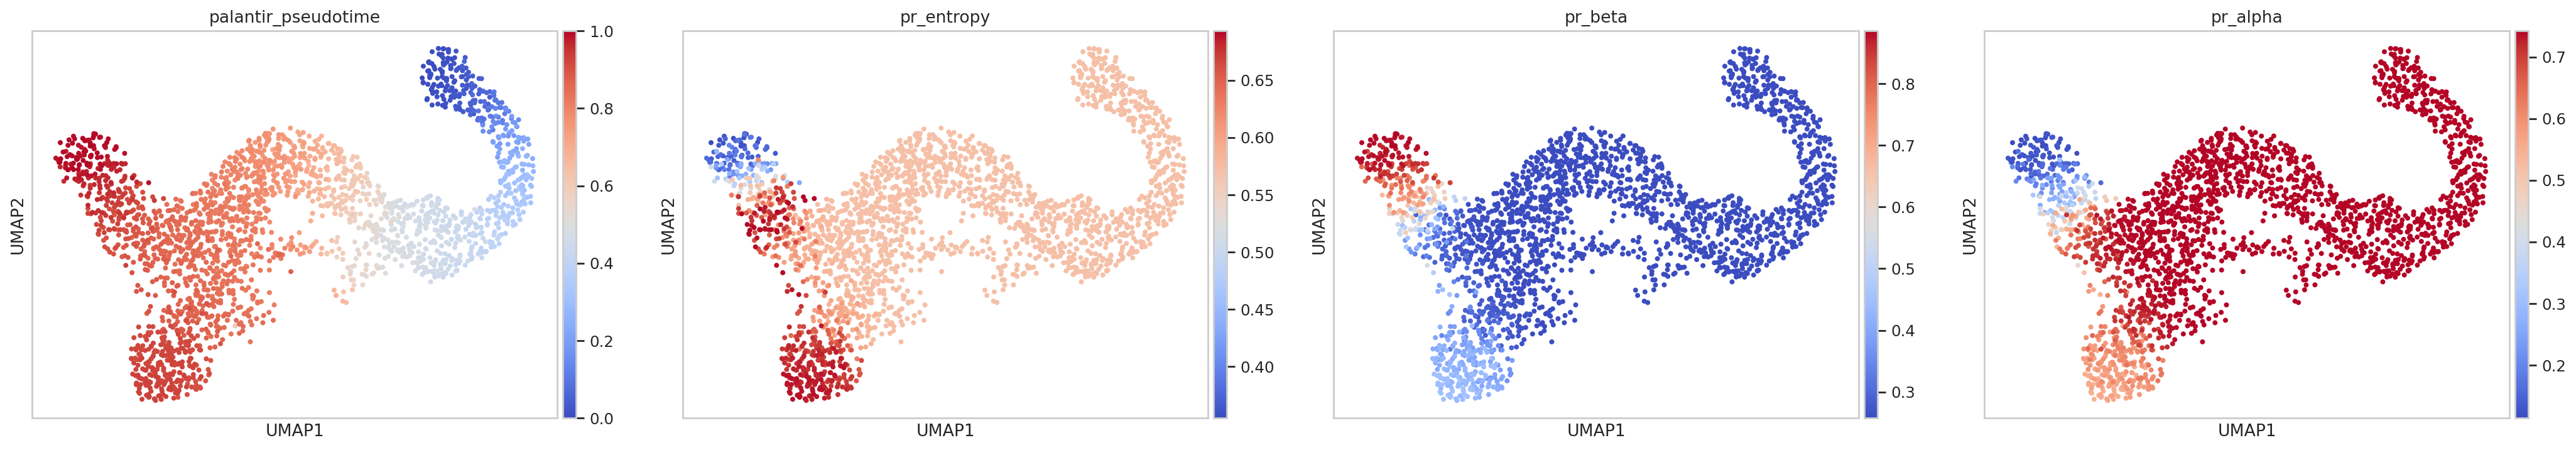

In [23]:
sc.pl.umap(adata, color=["palantir_pseudotime", "pr_entropy", "pr_beta", "pr_alpha"], cmap="coolwarm")

Итак, псевдовремя здесь также вышло очень неплохо, чего не скажешь об альфа кластере и энтропии. 
На графике энтропии получается, что она высокая вовсе не в точке ветвления, а в терминальной точке альфа кластера что очень странно, но хорошо, что она низкая в терминальной точке бета кластера. Также из графика для альфа кластера получается, что вероятность прийти в альфа кластер высокая везде, кроме бета кластера и терминальной точки альфа кластера, что прям вообще странно. Так что выходит, что с удалением двух кластеров все стало похуже.


## Часть 2

In [24]:
adata = adata_raw.copy()

In [25]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [26]:
scv.tl.recover_dynamics(adata, n_jobs=-1)
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)

recovering dynamics (using 2/2 cores)


  0%|          | 0/762 [00:00<?, ?gene/s]

    finished (0:04:36) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [27]:
scv.settings.set_figure_params("scvelo")

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


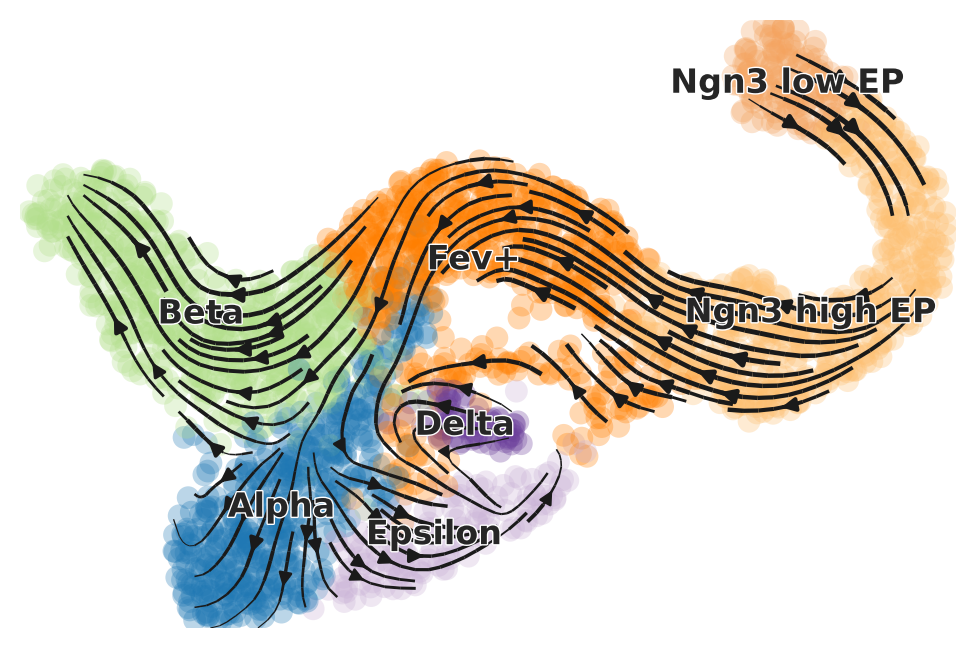

In [28]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=12, title="", smooth=0.4, min_mass=4
)

/usr/local/lib/python3.8/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


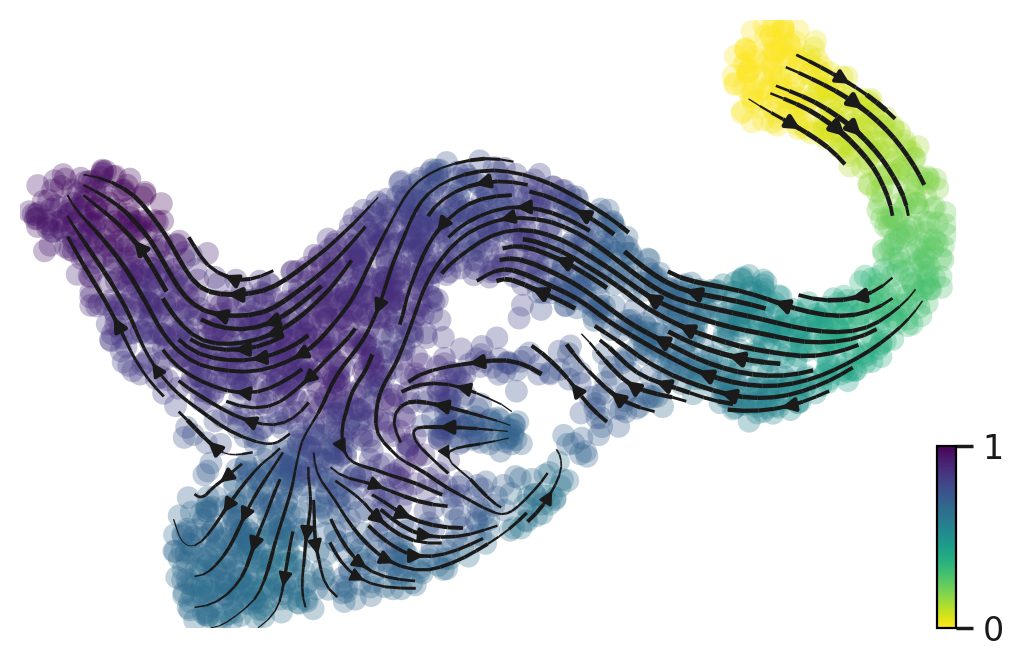

In [29]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=12, title="", smooth=0.4, min_mass=4, color="latent_time"
)

In [30]:
from cellrank.tl.estimators import GPCCA
kernel = cr.tl.transition_matrix(adata, weight_connectivities=0.2, n_jobs=-1, mode='monte_carlo') # ~6 minutes
g = GPCCA(kernel)
g.compute_schur(n_components=20)
g.compute_macrostates(cluster_key="clusters", n_states=12)

Computing transition matrix based on logits using `'monte_carlo'` mode


<ipython-input-30-a48ce29dab50>:2: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = cr.tl.transition_matrix(adata, weight_connectivities=0.2, n_jobs=-1, mode='monte_carlo') # ~6 minutes


Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/2531 [00:00<?, ?cell/s]

Setting `softmax_scale=3.7939`


  0%|          | 0/2531 [00:00<?, ?sample/s]

    Finish (0:04:37)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 8, 13, 15, 17, 20]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:29)
Computing `12` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:18)


In [32]:
g.set_terminal_states_from_macrostates(names=["Epsilon_1", "Alpha", "Beta"])
g.compute_absorption_probabilities()

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing absorption probabilities
Defaulting to `'gmres'` solver.


  0%|          | 0/3 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


In [33]:
cr.tl.lineage_drivers(adata)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


<ipython-input-33-b827be8b05bf>:1: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineage_drivers(adata)


Epsilon_1_corr  Epsilon_1_pval  Epsilon_1_qval  Epsilon_1_ci_low  \
index                                                                       
Ghrl           0.703650    0.000000e+00    0.000000e+00          0.683425   
Anpep          0.523284   1.688698e-187   1.266523e-184          0.494402   
Mboat4         0.484719   6.025794e-156   1.506449e-153          0.454338   
Cdkn1a         0.464778   2.480005e-141   3.720007e-139          0.433669   
Gm11837        0.438678   9.088402e-124   1.239328e-121          0.406667   
...                 ...             ...             ...               ...   
Ins2          -0.473822   7.950388e-148   1.490698e-145         -0.503489   
Iapp          -0.476647   6.711590e-150   1.438198e-147         -0.506208   
Pcsk2         -0.501066   9.157889e-169   2.747367e-166         -0.529687   
Nnat          -0.507894   2.347451e-174   8.802940e-172         -0.536245   
Ppp1r1a       -0.515628   7.270408e-181   3.635204e-178         -0.543668   

         Epsilon_1_ci_high  Alpha_corr    Alpha_pval    Alpha_qval  \
index                                                                
Ghrl              0.722796   -0.130849  3.667917e-11  2.973986e-10   
Anpep             0.551011   -0.110121  2.707778e-08  1.631192e-07   
Mboat4            0.513974   -0.133668  1.368533e-11  1.146816e-10   
Cdkn1a            0.494780   -0.205153  1.272031e-25  2.750864e-24   
Gm11837           0.469613   -0.083382  2.643841e-05  1.156199e-04   
...                    ...         ...           ...           ...   
Ins2             -0.443039   -0.334291  2.048627e-68  1.463305e-66   
Iapp             -0.445967    0.103587  1.722608e-07  9.605623e-07   
Pcsk2            -0.471305    0.176739  2.693061e-19  3.672356e-18   
Nnat             -0.478399   -0.356216  2.751490e-78  2.579522e-76   
Ppp1r1a          -0.486439   -0.093371  2.497249e-06  1.220154e-05   

         Alpha_ci_low  Alpha_ci_high  Beta_corr      Beta_pval      Beta_qval  \
index                                                                           
Ghrl        -0.168949      -0.092358  -0.413541  2.189148e-108  1.641861e-106   
Anpep       -0.148446      -0.071466  -0.297585   1.043648e-53   3.010524e-52   
Mboat4      -0.171736      -0.095202  -0.251062   4.564079e-38   7.779680e-37   
Cdkn1a      -0.242179      -0.167530  -0.180937   3.625691e-20   3.055358e-19   
Gm11837     -0.121948      -0.044565  -0.256411   1.051066e-39   1.922682e-38   
...               ...            ...        ...            ...            ...   
Ins2        -0.368454      -0.299226   0.606556  5.096066e-274  2.548033e-271   
Iapp         0.064887       0.141976   0.268514   1.462707e-43   3.179797e-42   
Pcsk2        0.138732       0.214226   0.229574   6.875716e-32   9.729786e-31   
Nnat        -0.389768      -0.321719   0.648531   0.000000e+00   0.000000e+00   
Ppp1r1a     -0.131854      -0.054608   0.450036  3.336228e-131  2.943730e-129   

         Beta_ci_low  Beta_ci_high  
index                               
Ghrl       -0.445328     -0.380713  
Anpep      -0.332689     -0.261657  
Mboat4     -0.287214     -0.214195  
Cdkn1a     -0.218359     -0.142983  
Gm11837    -0.292451     -0.219644  
...              ...           ...  
Ins2        0.581332      0.630614  
Iapp        0.231980      0.304293  
Pcsk2       0.192333      0.266155  
Nnat        0.625371      0.670550  
Ppp1r1a     0.418411      0.480572  

[1500 rows x 15 columns]

In [35]:
adata = adata[:, list((adata.varm['terminal_lineage_drivers']['Epsilon_1_corr'] > 0.45) & (adata.varm['terminal_lineage_drivers']['Alpha_corr'] < 0.05) & (adata.varm['terminal_lineage_drivers']['Beta_corr'] < 0.05))]

In [36]:
adata

View of AnnData object with n_obs × n_vars = 2531 × 4
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'terminal_states', 'terminal_states_probs'
    var: 'highly_variable_genes', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'log1p', 'hvg', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'T_fwd_params', 'schur_matrix_fwd', 'e

/usr/local/lib/python3.8/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


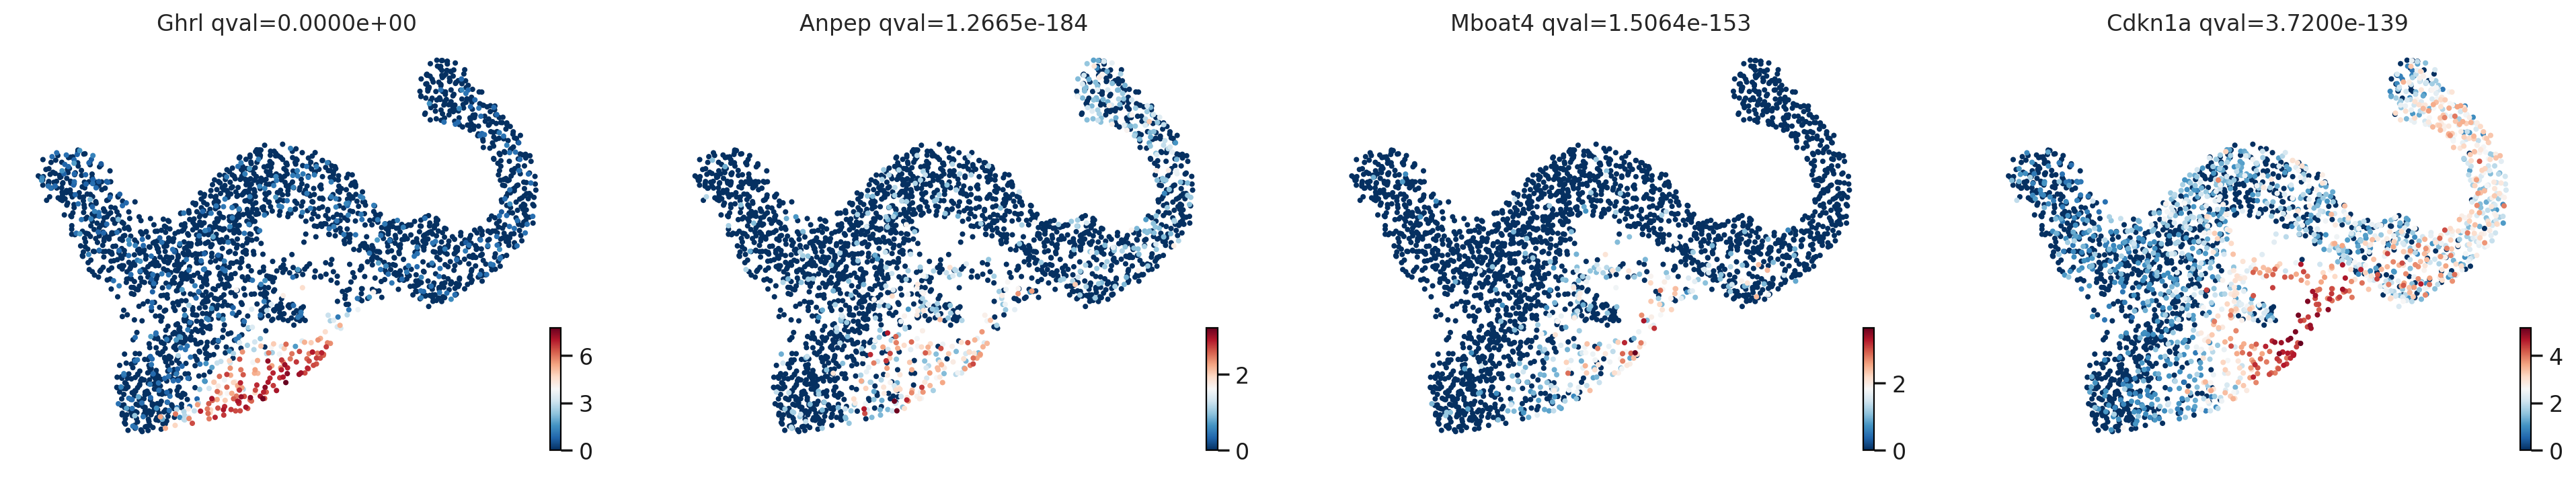

In [37]:
cr.pl.lineage_drivers(adata, lineage="Epsilon_1")

In [38]:
terminal = adata[adata.X.sum(axis=1).argmax(), :].obs.index

In [39]:
adata = adata_raw

In [40]:
cluster_dict = {"Epsilon": adata.obs["clusters"] == "Epsilon"}

In [41]:
epsilon_cell = terminal[0]

In [42]:
cluster_cells = {"Epsilon": adata.obs.index==epsilon_cell}

In [44]:
sce.tl.palantir(adata, n_components=5, knn=30)

Determing nearest neighbor graph...


In [45]:
sc.tl.tsne(adata, n_pcs=2, use_rep='X_palantir_multiscale', perplexity=90)

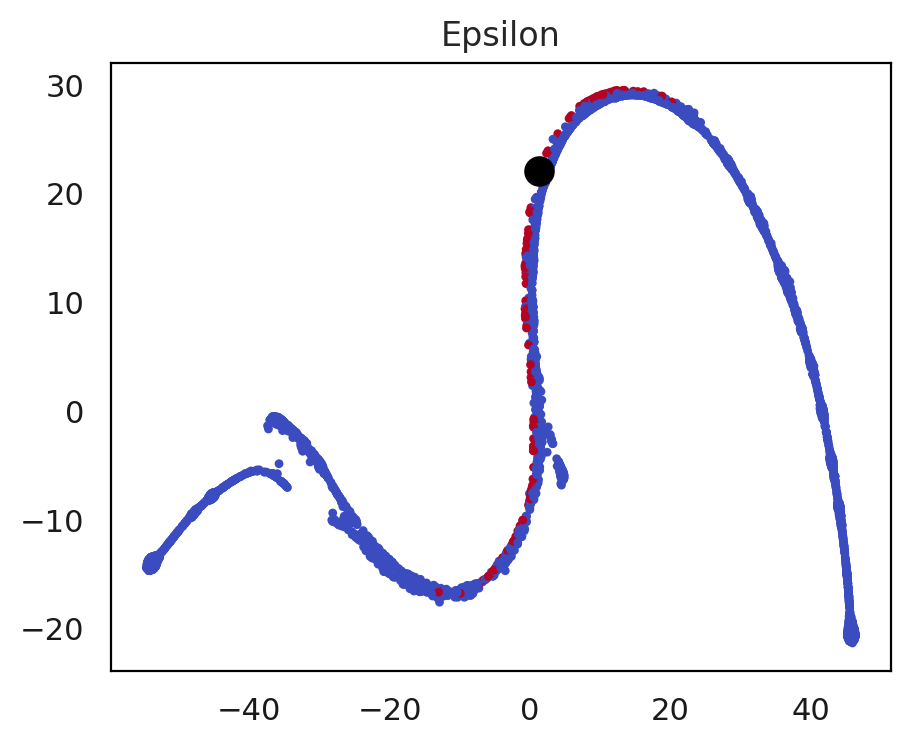

In [51]:
fig,axs = plt.subplots(1,1,figsize=(5,4))
for i, ax in enumerate(fig.axes):
  cur_cluster = list(cluster_dict.keys())[i]
  sns.scatterplot(adata.obsm["X_tsne"][:,0], adata.obsm["X_tsne"][:,1], c=cluster_dict[cur_cluster], ax=ax, cmap="coolwarm", linewidth=0, s=10)
  ax.scatter(adata.obsm["X_tsne"][:,0][cluster_cells[cur_cluster]],
             adata.obsm["X_tsne"][:,1][cluster_cells[cur_cluster]], c="black", s=100)
  ax.set_title(cur_cluster)

По поводу того, что видно на T-sne сказать тяжело, потому что клетки распределены по большому участку траектории. В целом, точка оказалась где-то посередине, наверное это все же не очень хорошо.

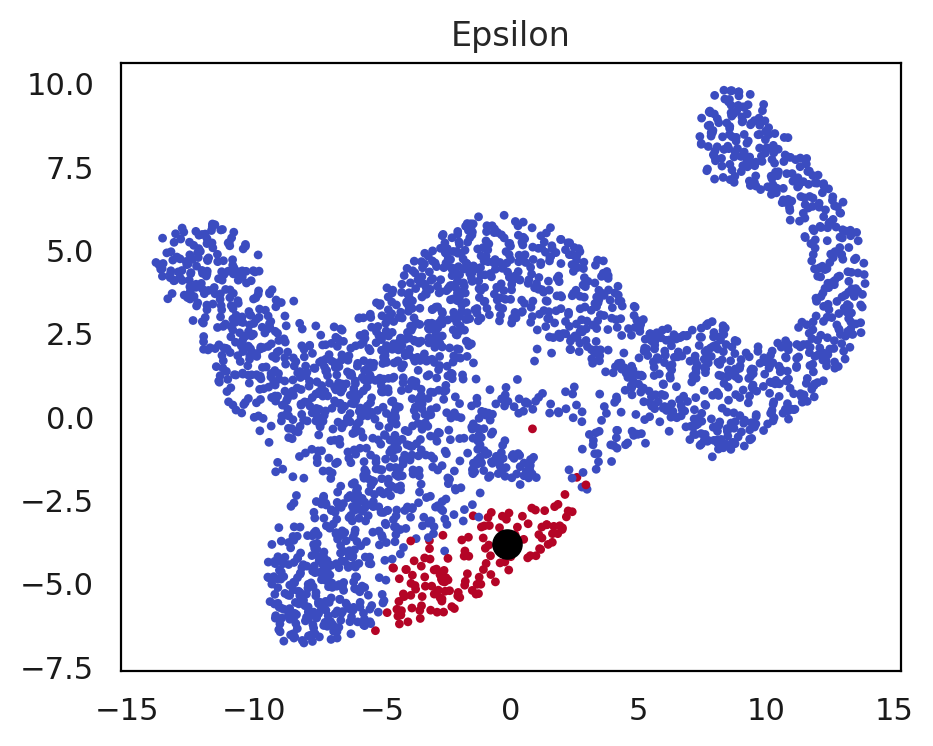

In [52]:

fig,axs = plt.subplots(1,1,figsize=(5,4))
for i, ax in enumerate(fig.axes):
  cur_cluster = list(cluster_dict.keys())[i]
  sns.scatterplot(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1], c=cluster_dict[cur_cluster], ax=ax, cmap="coolwarm", linewidth=0, s=10)
  ax.scatter(adata.obsm["X_umap"][:,0][cluster_cells[cur_cluster]],
             adata.obsm["X_umap"][:,1][cluster_cells[cur_cluster]], c="black", s=100)
  ax.set_title(cur_cluster)

А на этом графике положение точки стало больше похоже на предсказание RNA velocity, что ожидаемо, потому что CellRank использует данные от туда, но странно, что она все же близка к середине 